# **Sentiment Analysis using BERT**

In [ ]:
#Installing Dependencies
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 35.0 MB/s 
     |████████████████████████████████| 895 kB 48.8 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df=pd.read_csv('/tmp/reviews (2).csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [ ]:
df.shape

(12495, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [ ]:
# Let's check for missing values 
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


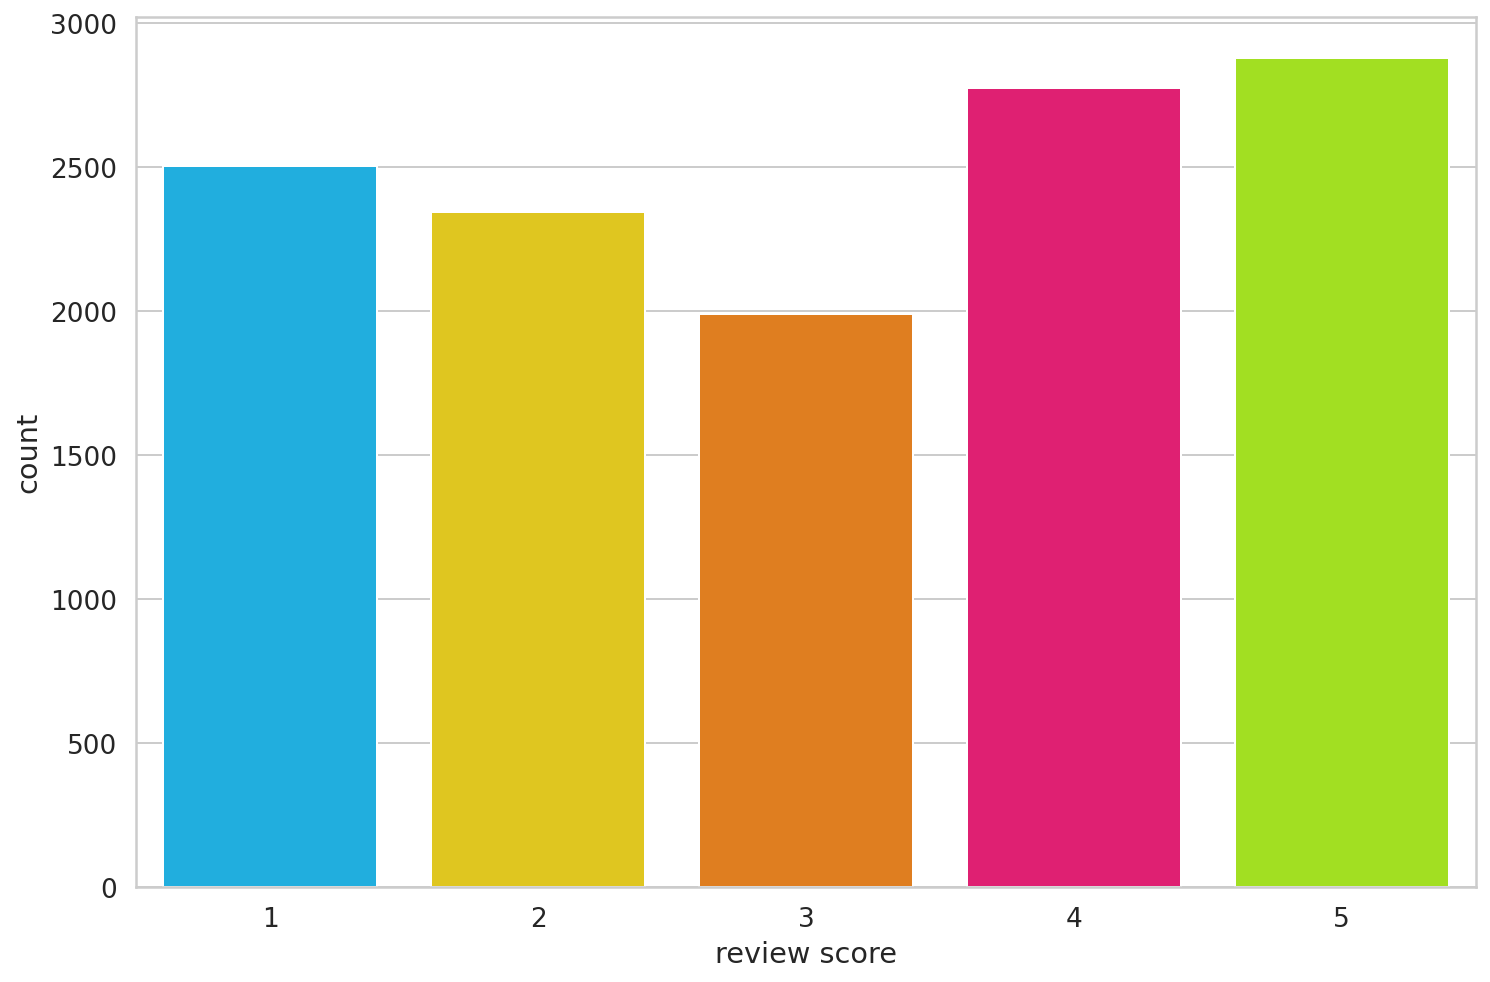

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
def group_sentiment(rating):
  #rating = int(rating)
  if rating <= 2:
    return 0         # Negetive sentiment
  elif rating == 3:
    return 1         # Neutral Sentiment
  else: 
    return 2         # positive Sentiment

df['sentiment'] = df.score.apply(group_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


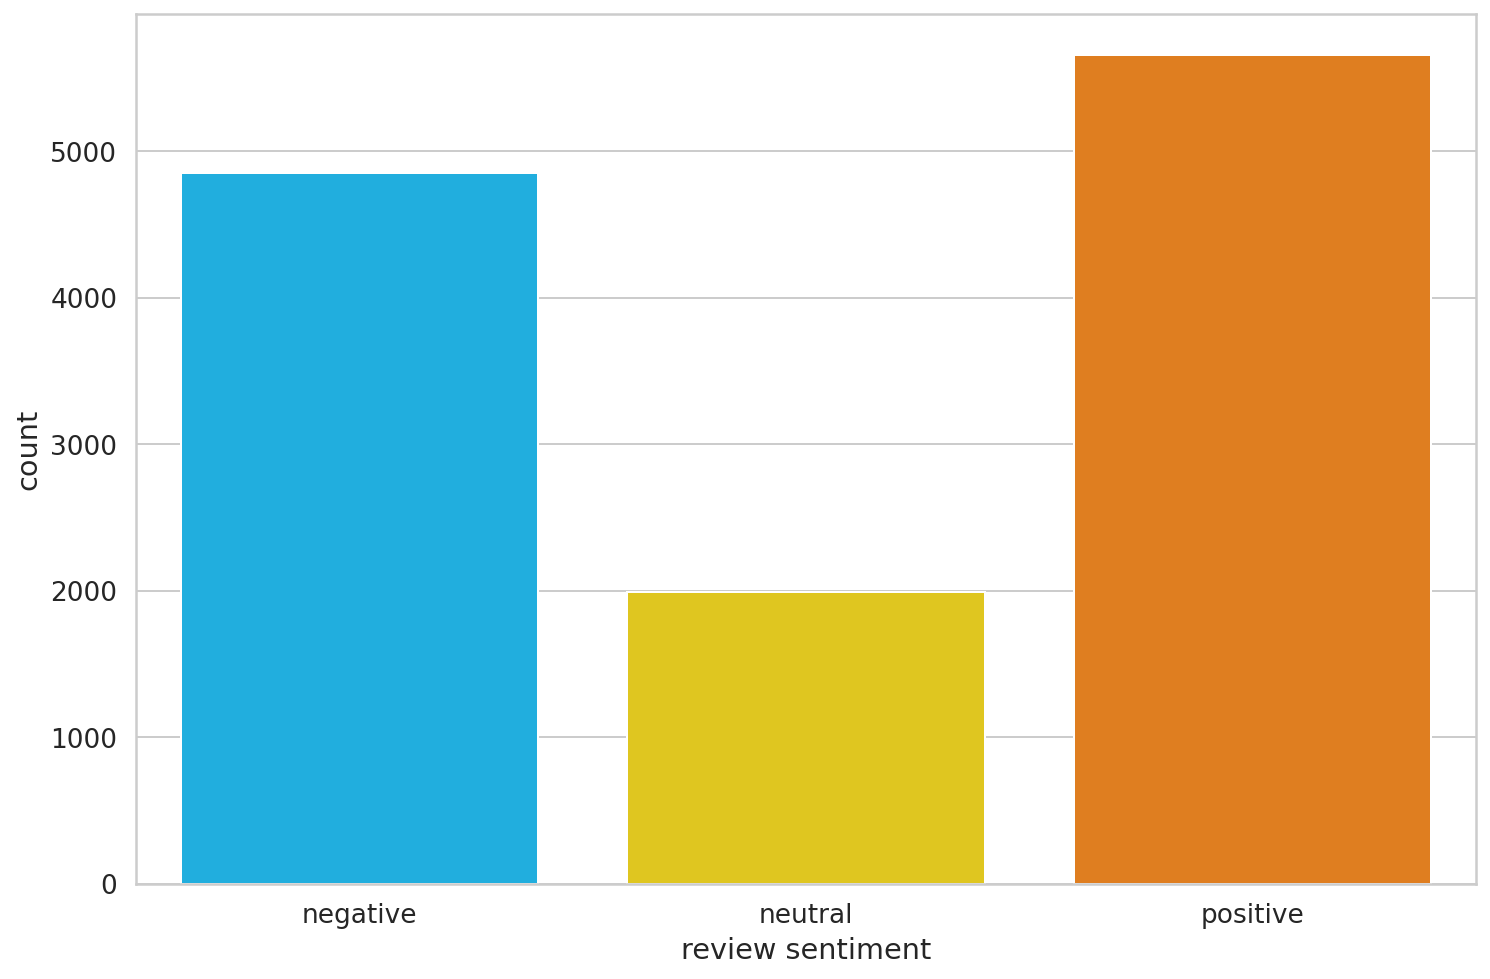

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# We'll use this simple text to understand the tokenization process:

In [ ]:
sample_txt = 'Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Sentence: {sample_txt}')
print(f'\n  Tokens: {tokens}')
print(f'\n  Token IDs: {token_ids}')   # Each token has a an unique ID for the model to unserstand what we are referring to.

  Sentence: Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.

  Tokens: ['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']

  Token IDs: [1798, 1282, 1115, 146, 1138, 3891, 136, 10271, 1108, 1103, 1211, 2712, 1105, 146, 4615, 1991, 6918, 1106, 1138, 3891, 10271, 1120, 1216, 1126, 1346, 1425, 119]


In [ ]:
len(tokens)

27

##Special Tokens

[SEP] - marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of the above work can be done using the encode_plus() method

In [ ]:
encoding_test = tokenizer.encode_plus(
  sample_txt,
  max_length=32,           # sequence length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoding_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(' length of the first sequence is :  ', len(encoding_test['input_ids'][0]))
print('\n The input id\'s are : \n', encoding_test['input_ids'][0])
print('\n The attention mask generated is : ', encoding_test['attention_mask'][0])

 length of the first sequence is :   32

 The input id's are : 
 tensor([  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
         1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
         3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102,     0,
            0,     0])

 The attention mask generated is :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0])


In [ ]:
#We can inverse the tokenization to have a look at the special tokens
tokenizer.convert_ids_to_tokens(encoding_test['input_ids'].flatten())

['[CLS]',
 'Best',
 'place',
 'that',
 'I',
 'have',
 'visited',
 '?',
 'Iceland',
 'was',
 'the',
 'most',
 'beautiful',
 'and',
 'I',
 'consider',
 'myself',
 'lucky',
 'to',
 'have',
 'visited',
 'Iceland',
 'at',
 'such',
 'an',
 'early',
 'age',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]']


BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review

In [ ]:
token_lens = []
for text in df.content:
    tokens_df = tokenizer.encode(text, max_length=512)   # Max possible length for the BERT model.
    token_lens.append(len(tokens_df))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


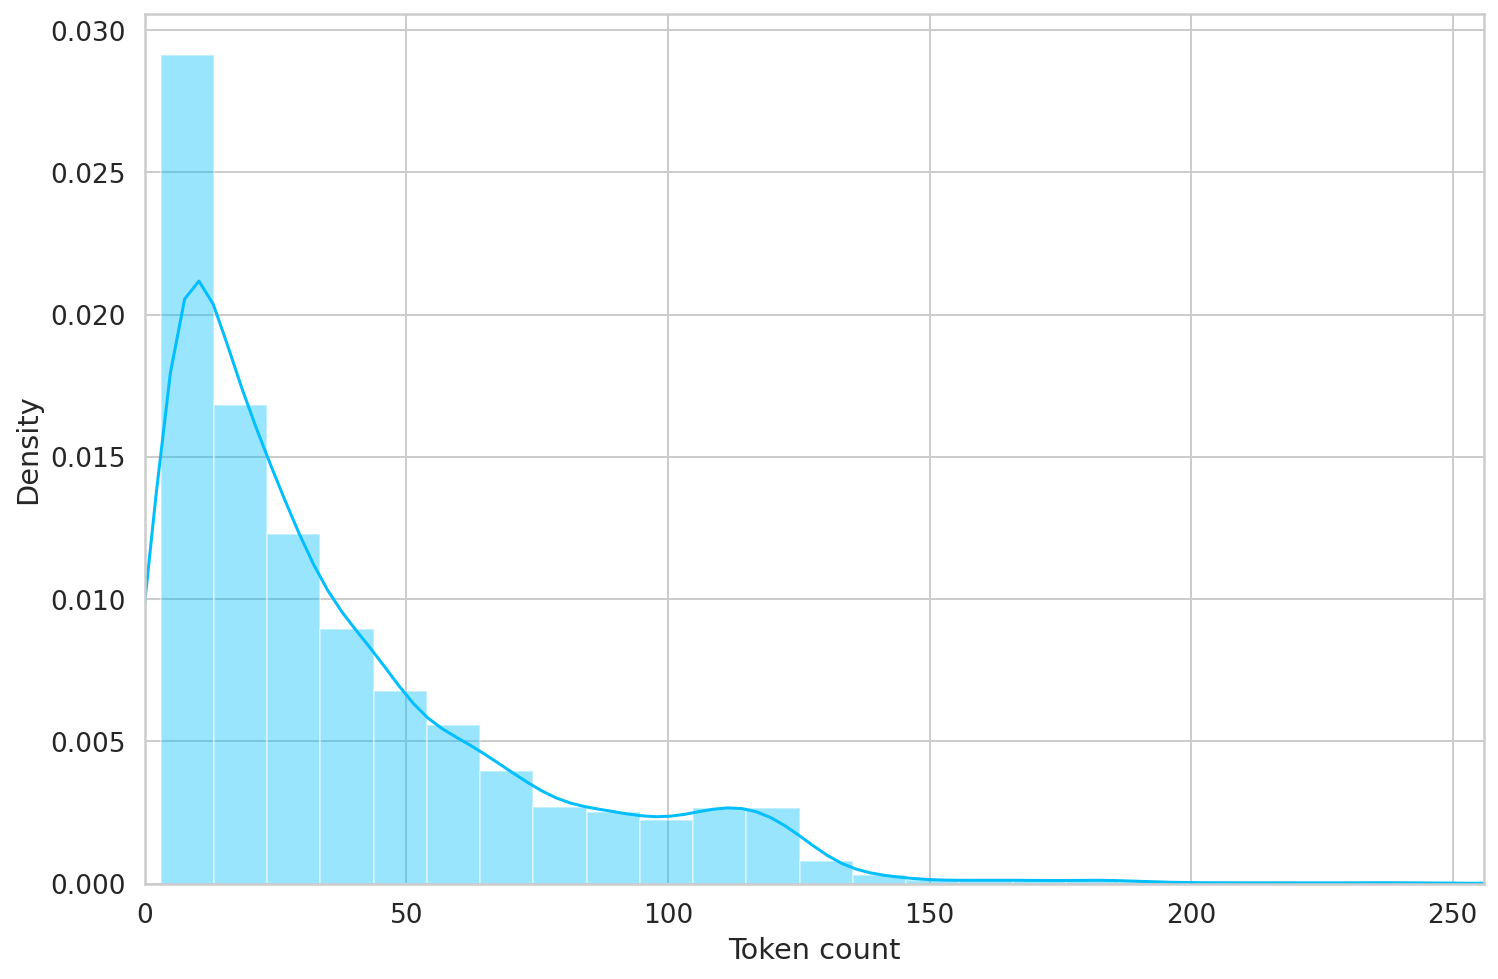

In [ ]:
#plot the distribution of review lenghts
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's use the same class:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews         # Reviews is content column.
    self.targets = targets         # Target is the sentiment column.
    self.tokenizer = tokenizer     # Tokenizer is the BERT_Tokanizer.
    self.max_len = max_len         # max_length of each sequence.
  
  def __len__(self):
    return len(self.reviews)       # Len of each review.
  
  def __getitem__(self, item):
    review = str(self.reviews[item])   # returns the string of reviews at the index = 'items'
    target = self.targets[item]        # returns the string of targets at the index = 'items'

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,                                   
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)            # dictionary containing all the features is returned.
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

##Splitting into train and validation sets

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((9996, 13), (1249, 13), (1250, 13))

Create data loaders for to feed as input to our model. The below function does that.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.values,
    targets=df.sentiment.values,
    tokenizer=tokenizer,
    max_len=max_len
  )                                  # Dataset would be created which can be used to create and return dataloader.

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


##Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_test = bert_model(
  input_ids=encoding_test['input_ids'], 
  attention_mask=encoding_test['attention_mask']
)
model_test.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

The "last_hidden_state" is a sequence of hidden states of the last layer of the model. Obtaining the "pooled_output" is done by applying the BertPooler which basically applies the tanh function to pool all the outputs.

In [ ]:
last_hidden_state=model_test['last_hidden_state']
pooled_output=model_test['pooler_output']

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence) and 768 is the number of hidden units in the feedforward-networks. We can verify that by checking the config

In [ ]:
bert_model.config.hidden_size

768


We can think of the pooled_output as a summary of the content, according to BERT. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all this knowledge to create a sentiment classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)                                 ## For regularization with dropout probability 0.3.
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) ## append an Output fully connected layer representing the number of classes
  
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 160])
torch.Size([8, 160])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2208, 0.5209, 0.2583],
        [0.2391, 0.3169, 0.4439],
        [0.3172, 0.2849, 0.3979],
        [0.2158, 0.3780, 0.4061],
        [0.5943, 0.1982, 0.2074],
        [0.2344, 0.4217, 0.3439],
        [0.3142, 0.2679, 0.4179],
        [0.3732, 0.2454, 0.3813]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

##Training the model

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face.

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS    # Number of batches * Epochs (Required for the scheduler.)
 
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,     # Recommended in the BERT paper.
  num_training_steps=total_steps  
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()    # To make sure that the droupout and normalization is enabled during the training.

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_prob, preds = torch.max(outputs, dim=1)    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()     # Back_Propogation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Recommended by the BERT paper to clip the gradients to avoid exploding gradients.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)     # Return the mean loss and the ratio of correct predictions.

Helper function to evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()        # To make sure that the droupout and normalization is disabled during the training.

  losses = []
  correct_predictions = 0

  with torch.no_grad():        # Back propogation is not required. Torch would perform faster. 
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_prob, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)          # Similar to Keras library saves history
best_accuracy = 0                    

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 5)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/10
-----
Train loss 0.7234952502131462 accuracy 0.7194877951180473
Val   loss 0.5935090855713103 accuracy 0.7630104083266612

Epoch 2/10
-----
Train loss 0.5427299129635096 accuracy 0.7981192476990797
Val   loss 0.6489102670650004 accuracy 0.7718174539631705

Epoch 3/10
-----
Train loss 0.4419369522344321 accuracy 0.854341736694678
Val   loss 0.872435268352793 accuracy 0.7502001601281024

Epoch 4/10
-----
Train loss 0.362521566407755 accuracy 0.9018607442977191
Val   loss 1.0931306571231052 accuracy 0.7510008006405123

Epoch 5/10
-----
Train loss 0.28100870738103984 accuracy 0.9313725490196079
Val   loss 1.3374815029707576 accuracy 0.7429943955164131

Epoch 6/10
-----
Train loss 0.22885648950710893 accuracy 0.947278911564626
Val   loss 1.3794908696773704 accuracy 0.7373899119295436

Epoch 7/10
-----
Train loss 0.1907406581393443 accuracy 0.9582833133253302
Val   loss 1.4517728837969222 accuracy 0.743795036028823

Epoch 8/10
-----
Train loss 0.1425458329075016 accuracy 0.9697879

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.7248

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.78      0.76       480
     neutral       0.37      0.36      0.36       216
    positive       0.85      0.82      0.83       554

    accuracy                           0.72      1250
   macro avg       0.65      0.65      0.65      1250
weighted avg       0.72      0.72      0.72      1250



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

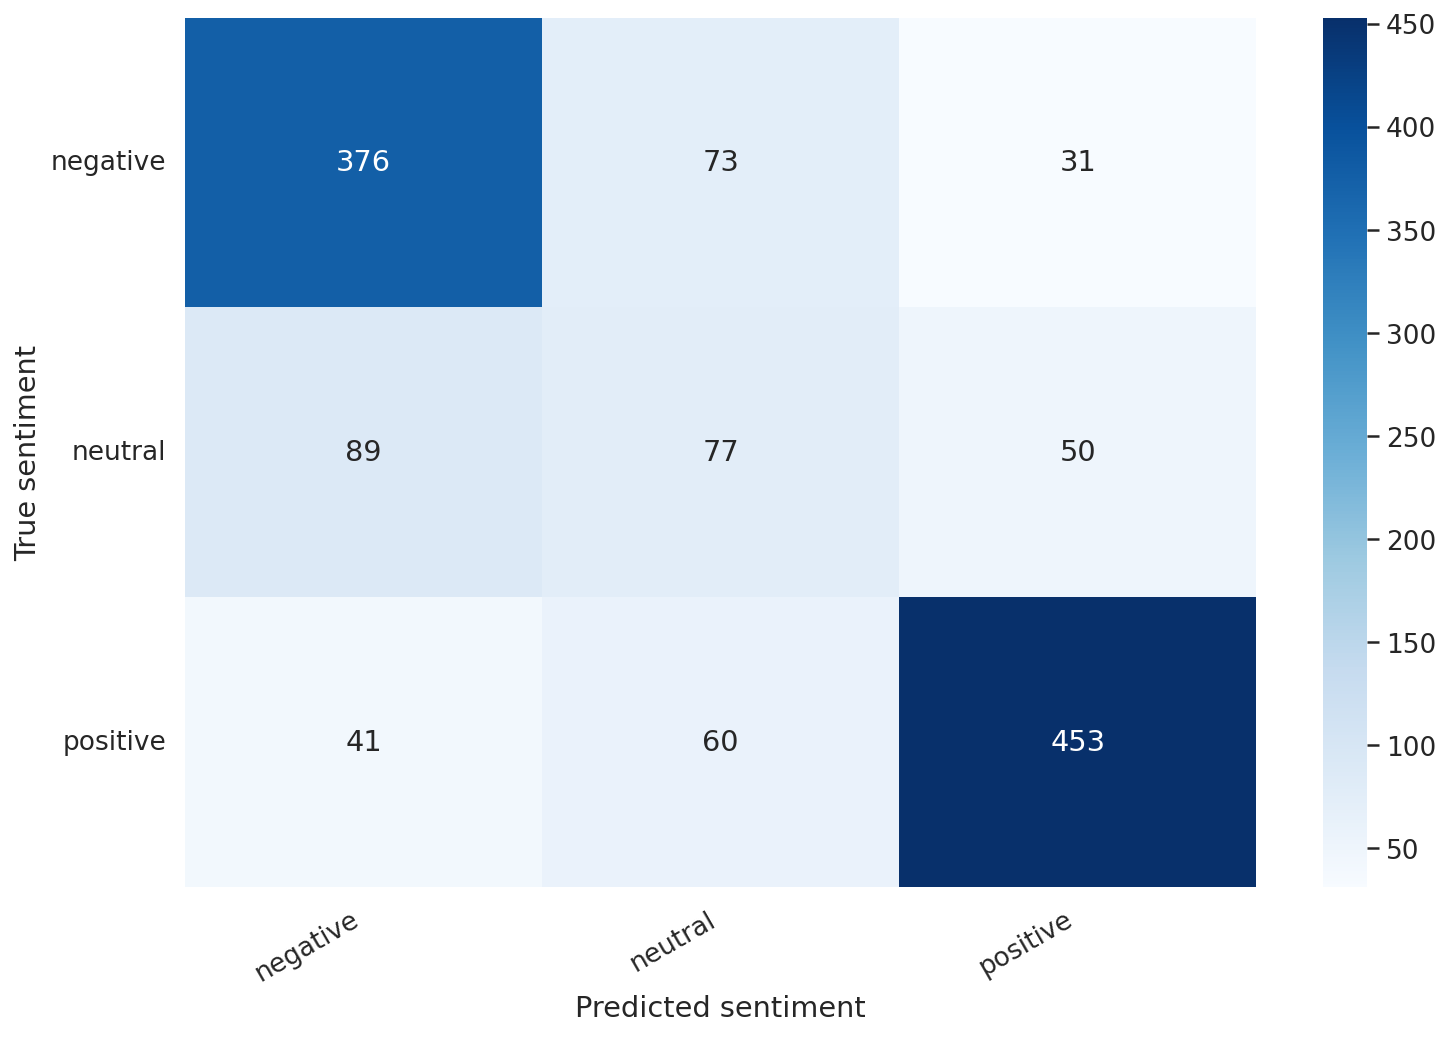

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Easy to use. No dramas. Very streamline for basic list use.

True sentiment: positive


In [ ]:
review_text2 = "The flight was so good that while I arrived in India my baggage was sent to Germany which is 1000 km away.The flight was so good that while I arrived in India my baggage was sent to Germany The flight was so good that while I arrived in India my baggage was sent to Germany which is 1000 km away. Now should i take a beautiful 10 hour trip to Germany or will you do something?"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text2}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The flight was so good that while I arrived in India my baggage was sent to Germany which is 1000 km away.The flight was so good that while I arrived in India my baggage was sent to Germany The flight was so good that while I arrived in India my baggage was sent to Germany which is 1000 km away. Now should i take a beautiful 10 hour trip to Germany or will you do something?
Sentiment  : neutral
